# 载入数据

In [335]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import cufflinks as cf
import matplotlib.pyplot as plt
%matplotlib inline

In [336]:
road = './bike.csv'

def get_data(road):
    dat = pd.read_csv(road)
    dat.drop(['casual', 'registered'], axis = 1, inplace = True)
    return dat

data = get_data(road)

# 特征工程

In [337]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
count         10886 non-null int64
dtypes: float64(3), int64(6), object(1)
memory usage: 850.6+ KB


In [338]:
def data_application(data):
    data.datetime = pd.to_datetime(data.datetime)
    data['day'] = data.datetime.apply(lambda x: x.day)
    data['year'] = data.datetime.apply(lambda x: x.year)
    data['hour'] = data.datetime.apply(lambda x: x.hour)
    data['minute'] = data.datetime.apply(lambda x: x.minute)
    data['dayofweek'] = data.datetime.apply(lambda x: x.dayofweek)
    data['weekend'] = data.datetime.apply(lambda x: x.dayofweek in [5, 6])
    data.drop('datetime', axis = 1, inplace = True)

In [339]:
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


# 构建评价标准
$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\ln(p_i + 1) - \ln(a_i+1))^2 }$$

In [340]:
def post_pred(y_pred):
    y_pred[y_pred < 0] = 0
    return y_pred

def rmsle(y_true, y_pred, y_pred_only_postive = True):
    if y_pred_only_postive:
        y_pred = post_pred(y_pred)
    diff = np.log(y_pred + 1) - np.log(y_true + 1)
    mean_err = np.square(diff).mean()
    return np.sqrt(mean_err)

# 模型构建

## 拆分数据集

In [341]:
def assing_test_samples(data, test_ratio = 0.3, seed = 1):
    days = data.day.unique()
    np.random.seed(seed)
    np.random.shuffle(days)
    test_day = days[ :int(len(days) * test_ratio)]
    data['is_test'] = data.day.isin(test_day)

In [342]:
def get_x_y(data, target_variable):
    train_values = data.drop(target_variable, axis = 1).values
    target = data[target_variable].values
    return train_values, target
    
def train_test_split(data, target_variable):
    data_application(data)
    assing_test_samples(data)
    df_train = data[data.is_test == False]
    df_test = data[data.is_test == True]
    X_train, y_train = get_x_y(df_train, 'count')
    X_test, y_test = get_x_y(df_test, 'count')
    return X_train, y_train, X_test, y_test

## 拟合与预测

In [343]:
def fit_and_predict(data, model, target_variable):
    X_train, y_train, X_test, y_test = train_test_split(data, target_variable)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_test, y_pred

def count_prediction(data, model, target_variable = 'count'):
    y_test, y_pred = fit_and_predict(data, model, target_variable)
    return rmsle(y_test, y_pred, y_pred_only_postive = True)

## 模型特征重要性的可视化

In [344]:
def get_features(data, target_variable):
    return list(data.drop(target_variable, axis =1).columns)

In [345]:
def importance_features(model, data, target_variable):
    features = get_features(data, target_variable)
    impdf = []
    fscore = model.get_booster().get_fscore()
    maps_name = dict([('f{0}'.format(i), col) for i, col in enumerate(features)])
    
    for ft, score in fscore.items():
        impdf.append({'features': maps_name[ft], 'importance': score})
    impdf = pd.DataFrame(impdf)
    impdf = impdf.sort_values(by = 'importance', ascending = False).reset_index(drop = True)
    impdf['importance'] /= impdf['importance'].sum()
    impdf.index = impdf['features']
    impdf.drop('features', axis = 1, inplace = True)
    return impdf

In [346]:
def draw_importance_features(model, data, target_variable):
    impdf = importance_features(model, data, target_variable)
    impdf.iplot(kind = 'bar')

# 拟合模型

xgboost 0.731757795490329


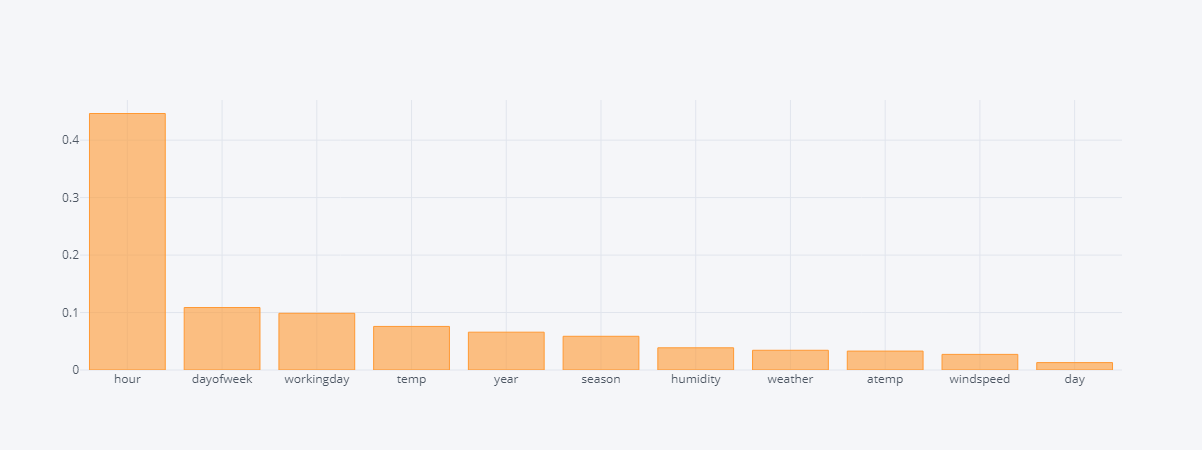

In [347]:
model = xgb.XGBRegressor(objective = 'reg:squarederror')
print('xgboost', count_prediction(data, model))
draw_importance_features(model, data, 'count')